In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(24)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/py38/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41197 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:37141 Dashboard: http://127.0.0.1:41197/status,Cluster Workers: 8 Cores: 56 Memory: 251.63 GiB


In [4]:
import numpy as np
import xarray as xr
import qgutils
from xgcm.grid import Grid
import os.path as op
# import gcm_filters
# import dask_image.ndfilters as ndfilters
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
ddir = '/store/tuchida/msom/msqg/filter/'

In [6]:
U = .1
T = 5e5      # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4     # Rossby radius (50km)
Re = 70.
Re4 = 1e3
# f0 = 8e-5
beta = .43
N = 256    # Number of horizontal grids
L0 = 100
H = 5e3
dx = L0/N    # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .0215
Ekb = .001
# ntime = 187

In [7]:
ds = xr.open_dataset(op.join(ddir,'N256/outdir_0005/vars.nc'))
# ds = xr.open_dataset(op.join(ddir,'LfullHeddy/outdir_0001/vars.nc'))

ds = ds.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
ds.coords['time'] = ('time',ds.time.data)
# ds.coords['Z'] = ('Z',np.array([.03,.13,.6]))
ds.coords['YG'] = ('YG',np.arange(0,L0,dx))
ds.coords['XG'] = ('XG',np.arange(0,L0,dx))
ds.coords['YC'] = ('YC',np.arange(dx/2,L0+dx/2,dx))
ds.coords['XC'] = ('XC',np.arange(dx/2,L0+dx/2,dx))
# ds.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
# ds.coords['drF'] = ('Z',np.array([0.04761905, 0.0952381 , 0.19047619, 0.66666667]))
# ds.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
ds

<xarray.Dataset>
Dimensions:  (XC: 256, XG: 256, YC: 256, YG: 256, Z: 4, time: 501)
Coordinates:
  * YC       (YC) float64 0.1953 0.5859 0.9766 1.367 ... 98.63 99.02 99.41 99.8
  * XC       (XC) float64 0.1953 0.5859 0.9766 1.367 ... 98.63 99.02 99.41 99.8
  * Z        (Z) float32 0.0 1.0 2.0 3.0
  * time     (time) float32 0.0 10.0 20.0 30.0 ... 4.98e+03 4.99e+03 5e+03
  * YG       (YG) float64 0.0 0.3906 0.7812 1.172 ... 98.44 98.83 99.22 99.61
  * XG       (XG) float64 0.0 0.3906 0.7812 1.172 ... 98.44 98.83 99.22 99.61
Data variables:
    p        (time, Z, YC, XC) float32 ...
    q        (time, Z, YC, XC) float32 ...
    pf       (time, Z, YC, XC) float32 ...

In [9]:
Jpq = xr.ones_like(ds.p.isel(Z=0)).load()

for i in range(len(ds.time)):
    Jpq[i] = qgutils.jacobian(ds.p.isel(time=i,Z=0).data, ds.q.isel(time=i,Z=0).data, dx)
Jpq

<xarray.DataArray 'p' (time: 501, YC: 256, XC: 256)>
array([[[-2.41191201e-02, -5.46264229e-03,  1.67119041e-01, ...,
          3.53014027e-03,  1.16244387e-02,  2.80947890e-04],
        [-1.97921097e-01, -3.33069235e-01, -3.28722820e-02, ...,
          4.98767849e-03,  6.72310451e-03, -5.86577365e-03],
        [-4.22445148e-01, -5.57703257e-01, -2.07475945e-01, ...,
          1.10790168e-03,  1.18562253e-02,  1.02381166e-02],
        ...,
        [ 1.68695316e-01,  6.24079049e-01,  9.62909400e-01, ...,
          3.13976151e-03,  4.49743774e-03,  4.57478082e-03],
        [ 3.71373385e-01,  7.78963864e-01,  6.51548982e-01, ...,
          3.18780914e-03,  3.68026597e-03,  1.08994097e-02],
        [ 7.42092133e-02,  9.83546227e-02,  4.42321822e-02, ...,
          4.54179198e-03, -6.71003805e-03,  3.95406096e-06]],

       [[-2.92835440e-02, -5.11582941e-02,  9.22230445e-03, ...,
          2.69437721e-03,  1.33596978e-03,  3.49131209e-04],
        [-1.55554309e-01, -3.29091907e-01, -1.63643375e-01, ...,
          6.47952314e-03,  5.15915314e-03,  2.07317923e-03],
        [-2.17857778e-01, -4.07537252e-01, -2.29548082e-01, ...,
          4.26584622e-03,  7.86698982e-03,  4.73524677e-03],
...
         -2.38541490e-03, -1.18784644e-02, -7.88360275e-03],
        [ 3.14514458e-01,  4.52046990e-01,  1.38162956e-01, ...,
         -1.05591007e-02, -8.28755181e-03, -3.33559141e-03],
        [ 6.53207675e-02,  4.19337898e-02, -1.36034414e-01, ...,
         -4.73542372e-03, -2.14752462e-03, -5.12238301e-04]],

       [[ 1.57672688e-02,  5.09611666e-02,  5.70109189e-02, ...,
          6.37980993e-04,  2.77189014e-04,  6.27620248e-05],
        [ 2.42349450e-02,  5.32724299e-02,  9.34718829e-03, ...,
          8.94605881e-04,  7.75350491e-04,  3.28670576e-04],
        [ 3.78179527e-03, -3.54070961e-02, -1.30096227e-01, ...,
         -9.05029956e-05,  1.08922436e-03,  7.26139755e-04],
        ...,
        [-1.90113280e-02, -1.86454192e-01, -9.00890306e-02, ...,
         -1.40945269e-02, -2.05764640e-02, -1.04287649e-02],
        [ 4.17684257e-01,  6.06879771e-01,  1.59887046e-01, ...,
         -1.15324277e-02, -1.02696698e-02, -4.24379623e-03],
        [ 1.24210708e-01,  1.62189186e-01, -8.41401666e-02, ...,
         -4.74364124e-03, -2.29851482e-03, -6.22605032e-04]]],
      dtype=float32)
Coordinates:
  * YC       (YC) float64 0.1953 0.5859 0.9766 1.367 ... 98.63 99.02 99.41 99.8
  * XC       (XC) float64 0.1953 0.5859 0.9766 1.367 ... 98.63 99.02 99.41 99.8
    Z        float32 0.0
  * time     (time) float32 0.0 10.0 20.0 30.0 ... 4.98e+03 4.99e+03 5e+03

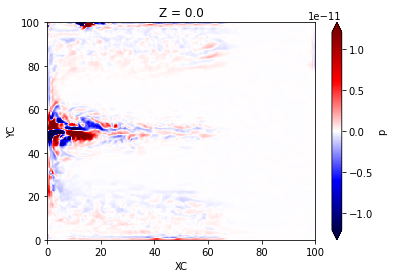

In [15]:
(Jpq.mean('time') * U*U/Rd/Rd).plot(vmax=1.2e-11, cmap='seismic')

In [16]:
N = 128    # Number of horizontal grids
dx = L0/N    # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd

In [17]:
ds = xr.open_dataset(op.join(ddir,'N128/outdir_0005/vars.nc'))
# ds = xr.open_dataset(op.join(ddir,'LfullHeddy/outdir_0001/vars.nc'))

ds = ds.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
ds.coords['time'] = ('time',ds.time.data)
# ds.coords['Z'] = ('Z',np.array([.03,.13,.6]))
ds.coords['YG'] = ('YG',np.arange(0,L0,dx))
ds.coords['XG'] = ('XG',np.arange(0,L0,dx))
ds.coords['YC'] = ('YC',np.arange(dx/2,L0+dx/2,dx))
ds.coords['XC'] = ('XC',np.arange(dx/2,L0+dx/2,dx))
# ds.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
# ds.coords['drF'] = ('Z',np.array([0.04761905, 0.0952381 , 0.19047619, 0.66666667]))
# ds.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
ds

<xarray.Dataset>
Dimensions:  (XC: 128, XG: 128, YC: 128, YG: 128, Z: 4, time: 501)
Coordinates:
  * YC       (YC) float64 0.3906 1.172 1.953 2.734 ... 97.27 98.05 98.83 99.61
  * XC       (XC) float64 0.3906 1.172 1.953 2.734 ... 97.27 98.05 98.83 99.61
  * Z        (Z) float32 0.0 1.0 2.0 3.0
  * time     (time) float32 0.0 10.0 20.0 30.0 ... 4.98e+03 4.99e+03 5e+03
  * YG       (YG) float64 0.0 0.7812 1.562 2.344 ... 96.88 97.66 98.44 99.22
  * XG       (XG) float64 0.0 0.7812 1.562 2.344 ... 96.88 97.66 98.44 99.22
Data variables:
    p        (time, Z, YC, XC) float32 ...
    q        (time, Z, YC, XC) float32 ...
    pf       (time, Z, YC, XC) float32 ...

In [18]:
Jpq_L = xr.ones_like(ds.p.isel(Z=0)).load()

for i in range(len(ds.time)):
    Jpq_L[i] = qgutils.jacobian(ds.p.isel(time=i,Z=0).data, ds.q.isel(time=i,Z=0).data, dx)
Jpq_L

<xarray.DataArray 'p' (time: 501, YC: 128, XC: 128)>
array([[[ 2.71661882e-03,  1.46806184e-02,  3.63370776e-02, ...,
          2.14660440e-06,  8.17683667e-06, -2.15923791e-07],
        [ 1.77422795e-03,  1.51843783e-02,  1.66439936e-02, ...,
          6.53184998e-06, -1.73484285e-08, -9.20932598e-06],
        [-1.15051167e-03,  6.44743675e-03,  8.66941083e-03, ...,
          2.63296465e-06, -6.31427929e-06, -4.09065797e-06],
        ...,
        [ 1.15436502e-03, -1.11515708e-02, -7.76974671e-03, ...,
         -1.78315213e-06, -1.04137262e-05, -6.40507642e-06],
        [-5.86122973e-03, -2.20389348e-02, -2.13219970e-02, ...,
         -3.11270867e-07, -5.91822982e-06,  9.56185977e-06],
        [-5.55862021e-03, -2.07258202e-02, -3.33407894e-02, ...,
         -9.51369714e-07, -1.66095961e-05, -1.57012641e-06]],

       [[ 3.55429528e-03,  1.10238111e-02,  1.19240163e-02, ...,
          6.31098601e-06,  2.10247140e-06, -1.00618912e-07],
        [ 2.19237828e-03,  1.05323549e-02,  1.02242865e-02, ...,
          6.82381506e-06, -7.09530582e-07, -2.07610287e-06],
        [-1.41895551e-03,  1.85729773e-03,  2.81404937e-03, ...,
         -2.62092300e-07, -7.95478809e-06, -5.31567912e-06],
...
         -4.73526342e-07,  6.72553483e-07,  4.01540603e-07],
        [-6.19140628e-04, -3.26796877e-03, -2.24189963e-02, ...,
         -6.44821284e-07,  4.65215408e-07,  3.22651687e-07],
        [-2.86446442e-03, -5.79623226e-03, -2.59768721e-02, ...,
         -3.86831402e-07,  1.21382769e-07,  1.04980792e-07]],

       [[ 5.92310820e-03,  8.18899088e-03, -6.76587410e-03, ...,
          7.70988109e-08,  6.55758186e-08,  1.59075082e-08],
        [ 9.00328159e-03,  1.24470601e-02, -8.60662851e-03, ...,
          1.75857267e-07,  1.72120906e-07,  4.47592754e-08],
        [ 3.24232271e-03,  1.45150106e-02,  3.05879628e-03, ...,
          1.77959720e-07,  1.84027115e-07,  4.57674680e-08],
        ...,
        [ 7.18592526e-03,  1.46889454e-03, -9.08571109e-03, ...,
         -7.19009165e-07, -7.10989809e-07, -1.98951398e-07],
        [ 7.07267260e-04, -3.71536706e-03, -2.25151721e-02, ...,
         -6.81846075e-07, -6.28497617e-07, -1.69130232e-07],
        [-2.36349693e-03, -6.49647415e-03, -2.44142376e-02, ...,
         -2.93783955e-07, -2.44935364e-07, -6.02049326e-08]]],
      dtype=float32)
Coordinates:
  * YC       (YC) float64 0.3906 1.172 1.953 2.734 ... 97.27 98.05 98.83 99.61
  * XC       (XC) float64 0.3906 1.172 1.953 2.734 ... 97.27 98.05 98.83 99.61
    Z        float32 0.0
  * time     (time) float32 0.0 10.0 20.0 30.0 ... 4.98e+03 4.99e+03 5e+03

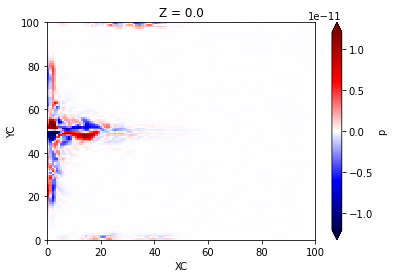

In [19]:
(Jpq_L.mean('time') * U*U/Rd/Rd).plot(vmax=1.2e-11, cmap='seismic')